# Results of Colombia’s Peace Plebiscite 2016

This notebook scrapes the official results of [Colombia's Peace Plebiscite](https://en.wikipedia.org/wiki/Colombian_peace_agreement_referendum,_2016) from the website of the [National Civil Registry of Colombia ("Registraduría Nacional del Estado Civil")](http://www.registraduria.gov.co).

The referendum to ratify the final agreement on the termination of the conflict between the Colombian government and guerillas was held on October 2, 2016. It failed with 50.2 percent voting against it and 49.8 percent voting in favor.

--- 

*[Christian Johannes Meyer](http://www.chrmeyer.com) (European University Institute)* & 
*[Juan Taborda Burgos](http://www.jctaborda.com) (Fletcher School of Law and Diplomacy)*

Distributed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

October 6, 2016

In [322]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feedparser
from bs4 import BeautifulSoup
import urllib
import urlparse
import re
import json
import difflib
from geopy.geocoders import GoogleV3, Nominatim, Bing, Photon
from fuzzywuzzy import fuzz
import difflib 
import folium

%matplotlib inline

Provide parameters

In [64]:
BASE_URL = 'http://plebiscito.registraduria.gov.co/'
STARTPOINT = '99PL/DPLZZZZZZZZZZZZZZZZZ_L1.htm'

## Obtain URL list for all departments and municipalities

Obtain URLs for all departments

In [114]:
# Initalize BeautifulSoup parser
soup = BeautifulSoup(urllib.urlopen(BASE_URL + STARTPOINT).read(), 'html.parser')

# Initalize empty dictionary to be filled below
departments = []

# Loop over departments and save url and name
for option in soup.find('select', id='combo2', class_='chosen-select').findAll('option'):
    relurl = option.get('value')
    absurl = BASE_URL + relurl[3:]
    department_name = option.contents[0].title()
    departments.append({
                    'url': absurl,
                    'department_name': department_name
                })

df_departments = pd.DataFrame(departments)

Obtain URLs for all municipalities

In [128]:
# Initalize empty dictionary to be filled below
municipalities = []

# Loop over all departments, open URL, and obtain municipal data
for d in df_departments.iterrows():

    # BeautifulSoup parser for department
    soup = BeautifulSoup(urllib.urlopen(d[1]['url']).read(), 'html.parser')
    
    try:
        f = soup.find('select', id='combo3', class_='chosen-select').findAll('option')
        
        for option in f:
            relurl = option.get('value')
            absurl = BASE_URL + relurl[3:]
            municipality_name = option.contents[0].title()
            municipalities.append({
                    'url': absurl,
                    'municipality_name': municipality_name,
                    'department_name': d[1]['department_name']
                })
        
    except(TypeError, AttributeError) as e:
        print('No municipalities for ' + d[1]['department_name'])
        pass
    
df_municipalities = pd.DataFrame(municipalities)

No municipalities for Todos


## Read out results

In [472]:
# Initalize empty dictionary to be filled below
data = []

# Loop over all URLs that we collected
for m in df_municipalities.iterrows():
    municipality_name = m[1]['municipality_name']
    department_name = m[1]['department_name']
    
    # BeautifulSoup parser for each page
    soup = BeautifulSoup(urllib.urlopen(m[1]['url']).read(), 'html.parser')

    # Metadata
    avancealas = soup.find('span', class_='resaltarHora').contents[0]
    resaltar = float(soup.find('span', class_='resaltar').contents[0].replace('.',''))

    # Mesas informadas
    mesas_percentage = float(soup.find('div', class_='cajaSupPrimeraContainer').find('span', class_='porcentajesCajas').contents[0][:-1].replace(',','.'))
    mesas_desc = soup.find('div', class_='cajaSupPrimeraContainer').find('span', class_='descripcionCaja').contents[0]
    res = re.split('de',mesas_desc)
    mesas_number = float(res[0][:-1].replace('.',''))
    mesas_total = float(res[1][:-17].replace('.',''))

    # Participation
    votacion_percentage = float(soup.find('div', class_='cajaSupSegundaContainer').find('span', class_='porcentajesCajas').contents[0][:-1].replace(',','.'))
    voation_desc = soup.find('div', class_='cajaSupSegundaContainer').find('span', class_='descripcionCaja').contents[0]
    res = re.split('de',voation_desc)
    votacion_personas_number = float(res[0][:-1].replace('.',''))
    votacion_personas_total = float(res[1][:-22].replace('.',''))

    # Results
    votedata = soup.findAll('div', class_='skill-bar-percent')
    si_percentage = float(votedata[0].contents[0][:-1].replace(',','.'))
    si_votes = float(votedata[1].contents[0][1:-7].replace('.',''))
    no_percentage = float(votedata[2].contents[0][:-1].replace(',','.'))
    no_votes = float(votedata[3].contents[0][1:-7].replace('.',''))

    # Vote numbers
    votosvalidos = unicode(soup.find('div', class_='cajaInfPrimera').find('div', class_='contenido'))[48:-6]
    votosnomarcados = unicode(soup.find('div', class_='cajaInfPrimera').find('div', class_='contenido'))[52:-6]
    votosnulos = unicode(soup.find('div', class_='cajaInfTercera').find('div', class_='contenido'))[46:-6]

    # Save data
    data.append({
                'department_name': department_name,
                'municipality_name': municipality_name,
                'url': m[1]['url'],
                'avancealas': avancealas,
                'resaltar': resaltar,
                'mesas_percentage': mesas_percentage,
                'mesas_number': mesas_number,
                'mesas_total': mesas_total,
                'votacion_percentage': votacion_percentage,
                'votacion_personas_number': votacion_personas_number,
                'votacion_personas_total': votacion_personas_total,
                'si_percentage': si_percentage,
                'si_votes': si_votes,
                'no_percentage': no_percentage,
                'no_votes': no_votes,
                'votosvalidos': votosvalidos,
                'votosnomarcados': votosnomarcados,
                'votosnulos': votosnulos
            })
    
df = pd.DataFrame(data)

In [473]:
df.to_csv('ColombiaPlebiscito2016_Results.csv',encoding='utf-8')

For further processing, delete departmental results

In [474]:
df = df[df.municipality_name != 'Todos']

# Add conflict data

Data on internally displaced population collected by UARIV, obtained via [Humanitarian Data Exchange](https://data.humdata.org/dataset/idps-data-by-year-and-municipality).

In [452]:
idps = pd.read_excel('static/desplazamiento-1999-2014.xlsx')
idps = idps.rename(columns = {'MUNICIPIO':'municipality_name'})
idps['municipality_name'] = map(lambda x: x.title(), idps['municipality_name'])

Take the mean across years

In [453]:
idps['idps_avg19992014'] = idps[[1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014]].mean(axis=1)

Fuzzy merge with scraped dataset

In [454]:
idps['municipality_name'] = idps['municipality_name'].apply(lambda x: (difflib.get_close_matches(x, df['municipality_name'])[:1] or [None])[0])
merged = pd.merge(df, idps[['municipality_name','idps_avg19992014']], on='municipality_name')

In [481]:
merged.to_csv('ColombiaPlebiscito2016_Results_withIDPs.csv',encoding='utf-8')

Take logs and see if there is any relationship

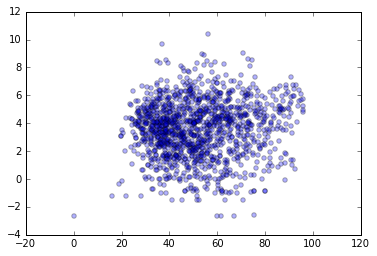

In [495]:
merged['ln_idps_avg19992014'] = np.log(merged['idps_avg19992014'])
plt.scatter(merged.si_percentage, merged.ln_idps_avg19992014, alpha=0.3)
plt.show()

In [497]:
idps

,DIVIPOLA,DEPARTAMENTO,municipality_name,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,idps_avg19992014
0,5001,ANTIOQUIA,Medellin,10040.0,4500.0,21000.0,23033.0,7436.0,19346.0,10043.0,16294.0,17301.0,26847.0,27284.0,17642,29460,16096,9952,2637,16181.937500
1,5002,ANTIOQUIA,Abejorral,0.0,0.0,91.0,56.0,6.0,129.0,42.0,26.0,58.0,35.0,15.0,53,28,45,11,17,38.250000
2,5004,ANTIOQUIA,Abriaqui,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,6.0,0.0,3.0,9,0,7,0,3,1.866667
3,5021,ANTIOQUIA,Alejandria,0.0,0.0,860.0,0.0,0.0,0.0,10.0,NaN,12.0,NaN,13.0,37,7,11,3,0,68.071429
4,5030,ANTIOQUIA,Amaga,0.0,0.0,0.0,8.0,0.0,10.0,51.0,24.0,37.0,16.0,15.0,40,10,71,131,47,28.750000
5,5031,ANTIOQUIA,Amalfi,0.0,0.0,50.0,0.0,4.0,21.0,0.0,22.0,39.0,48.0,31.0,149,5941,274,286,51,432.250000
6,5034,ANTIOQUIA,Andes,20.0,0.0,0.0,15.0,1.0,48.0,0.0,NaN,16.0,24.0,19.0,209,46,152,147,71,51.200000
7,5036,ANTIOQUIA,Angelopolis,120.0,0.0,135.0,0.0,0.0,7.0,0.0,NaN,0.0,0.0,14.0,27,11,12,68,1,26.333333
8,5038,ANTIOQUIA,Angostura,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7.0,1.0,NaN,61,6,34,75,32,15.428571
9,5040,ANTIOQUIA,Anori,0.0,0.0,160.0,0.0,3.0,248.0,45.0,26.0,102.0,2050.0,46.0,191,5045,335,352,65,541.750000
